In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [19]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train
    # ***************************************************
    test_y = y[k_indices[k]]
    test_x = x[k_indices[k]]
    train_k_indices = k_indices[[i for i in range(len(k_indices)) if i != 2]].ravel()
    train_y = y[train_k_indices]
    train_x = x[train_k_indices]
    # ***************************************************
    # form data with polynomial degree
    # ***************************************************
    phi_train_x = build_poly(train_x,degree)
    phi_test_x = build_poly(test_x,degree)
    # ***************************************************
    # ridge regression
    # ***************************************************
    weight_training = ridge_regression(train_y, phi_train_x, lambda_)
    # ***************************************************
    # calculate the loss for train and test data
    # ***************************************************
    loss_tr = np.sqrt(2*compute_mse(train_y,phi_train_x,weight_training))
    loss_te = np.sqrt(2*compute_mse(test_y,phi_test_x,weight_training))
    return loss_tr, loss_te

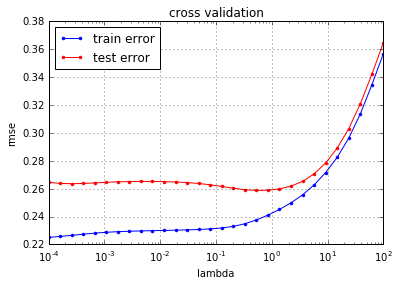

In [26]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 2, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    mse_tr = []
    mse_te = []
    # ***************************************************
    # cross validation
    # ***************************************************    
    for lamb in lambdas:
        loss_tr_acc = 0
        loss_te_acc = 0
        for k in range(len(k_indices)):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lamb, degree)
            loss_tr_acc += loss_tr
            loss_te_acc += loss_te
        mse_tr.append(loss_tr_acc/len(k_indices))
        mse_te.append(loss_te_acc/len(k_indices))
    cross_validation_visualization(lambdas, mse_tr, mse_te)
    
cross_validation_demo()

In [14]:
def cross_validate_multiple_degrees():
    """Use cross validate to obtain the optimal degree for ridge regression"""
    seed = 1
    degrees = range(2,11)
    k_fold = 4
    lambda_ = 1 #we fix the lambda
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    mse_tr = []
    mse_te = []
    # ***************************************************
    # cross validation
    # ***************************************************    
    for d in degrees:
        loss_tr_acc = 0
        loss_te_acc = 0
        for k in range(len(k_indices)):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, d)
            loss_tr_acc += loss_tr
            loss_te_acc += loss_te
        mse_tr.append(loss_tr_acc/len(k_indices))
        mse_te.append(loss_te_acc/len(k_indices))
        print("For d = ",d,"loss_tr = ",mse_tr[-1],"loss_te = ",mse_te[-1])
    min_loss_te = np.amin(mse_te)
    print(min_loss_te)
    optimal_degree = mse_te.index(min_loss_te)+2
    print("The optimal degree is ",optimal_degree)

cross_validate_multiple_degrees()

For d =  2 loss_tr =  0.458255218428 loss_te =  0.478256541712
For d =  3 loss_tr =  0.285184672766 loss_te =  0.295993848996
For d =  4 loss_tr =  0.259709964382 loss_te =  0.27223951304
For d =  5 loss_tr =  0.253963504761 loss_te =  0.26504971407
For d =  6 loss_tr =  0.253733119018 loss_te =  0.26500815822
For d =  7 loss_tr =  0.242834726651 loss_te =  0.259155502342
For d =  8 loss_tr =  0.242338426322 loss_te =  0.259110345749
For d =  9 loss_tr =  0.237953459771 loss_te =  0.263793699789
For d =  10 loss_tr =  0.233827355948 loss_te =  0.260082841372
0.259110345749
The optimal degree is  8


## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

/Users/hugomoreau/Dropbox/Etudes/Master/Pattern classification and machine learning/Labs/Lab4/template/split_data.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x_training = x[index_array[:bound]]
/Users/hugomoreau/Dropbox/Etudes/Master/Pattern classification and machine learning/Labs/Lab4/template/split_data.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y_training = y[index_array[:bound]]
/Users/hugomoreau/Dropbox/Etudes/Master/Pattern classification and machine learning/Labs/Lab4/template/split_data.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x_testing = x[index_array[bound:]]
/Users/hugomoreau/Dropbox/Etudes/Master/Pattern classification and machine learning/Labs/Lab4/template/split_data.py:22: VisibleDeprecationWarning: using a non-integer number instead

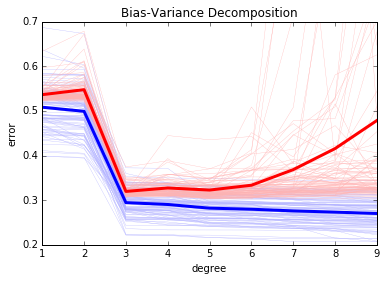

In [24]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed
        # ***************************************************
        training,testing = split_data(x, y, ratio_train, seed)
        x_training = training[0]
        y_training = training[1]
        x_testing = testing[0]
        y_testing = testing[1]
        # ***************************************************
        # bias_variance_decomposition
        # ***************************************************
        for index_degree,degree in enumerate(degrees):
            phi_train_x = build_poly(x_training,degree)
            phi_test_x = build_poly(x_testing,degree)
            mse,w = least_squares(y_training, phi_train_x)
            rmse_tr[index_seed][index_degree] = np.sqrt(2*mse)
            rmse_te[index_seed][index_degree] = np.sqrt(2*compute_mse(y_testing,phi_test_x,w))

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()